### Make the necessary imports (libraries)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import os
import time
import tarfile
import pickle
from tensorflow.keras.utils import to_categorical

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


### Load the data from a tar file (using pickle)

In [2]:
# If you're loading CIFAR-10 from a tar file
def load_pickle_from_tar(tar_path, pickle_path):
    with tarfile.open('/content/cifar-10-python.tar') as tar:
        member = tar.getmember(pickle_path)
        f = tar.extractfile(member)
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict

# Set your tar_path to the file in the same working folder
tar_path = "cifar-10-python.tar"  # File in the same working directory

# Load training data
train_data = []
train_labels = []

print("Loading training data...")
# The path structure below is based on the standard CIFAR-10 distribution
for i in range(1, 6):
    batch_path = f'cifar-10-batches-py/data_batch_{i}'
    print(f"Loading batch {i}...")
    batch_dict = load_pickle_from_tar(tar_path, batch_path)
    train_data.append(batch_dict[b'data'])
    train_labels.extend(batch_dict[b'labels'])

train_data = np.vstack(train_data)

Loading training data...
Loading batch 1...
Loading batch 2...
Loading batch 3...
Loading batch 4...
Loading batch 5...


### Load the training/test data set and label names

In [3]:
print("Loading test data...")
test_batch_path = 'cifar-10-batches-py/test_batch'
test_dict = load_pickle_from_tar(tar_path, test_batch_path)
test_data = test_dict[b'data']
test_labels = test_dict[b'labels']

# Load label names
print("Loading label names...")
meta_path = 'cifar-10-batches-py/batches.meta'
meta_dict = load_pickle_from_tar(tar_path, meta_path)
label_names = [label.decode('utf-8') for label in meta_dict[b'label_names']]

# Print basic info about the data
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Label names: {label_names}")


Loading test data...
Loading label names...
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Reshape the data to match the expected input format for CNN

In [4]:

# Each image is 32x32 pixels with 3 color channels (RGB)
X_train = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, 32, 32, 3)
X_test = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, 32, 32, 3)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Print updated shapes
print("Training data shape after reshaping:", X_train.shape)
print("Test data shape after reshaping:", X_test.shape)


Training data shape after reshaping: (50000, 32, 32, 3)
Test data shape after reshaping: (10000, 32, 32, 3)


### Conduct preprocessing of the data:
- Normalization (from 255 to 0/1)
- Convert class vectors to binary class matices (via one-hot encoding)
- Create validation data set (of 10% of training data)

In [5]:
def preprocess_data(X_train: np.ndarray, y_train: np.ndarray,
                    X_test: np.ndarray, y_test: np.ndarray):
    X_train, X_test = X_train / 255.0, X_test / 255.0
    y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

    val_size = int(0.1 * X_train.shape[0])
    return (X_train[:-val_size], y_train[:-val_size],
            X_train[-val_size:], y_train[-val_size:],
            X_test, y_test)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

### Let's do a quick visualization of sample images (to also ensure we still have the correct shape)

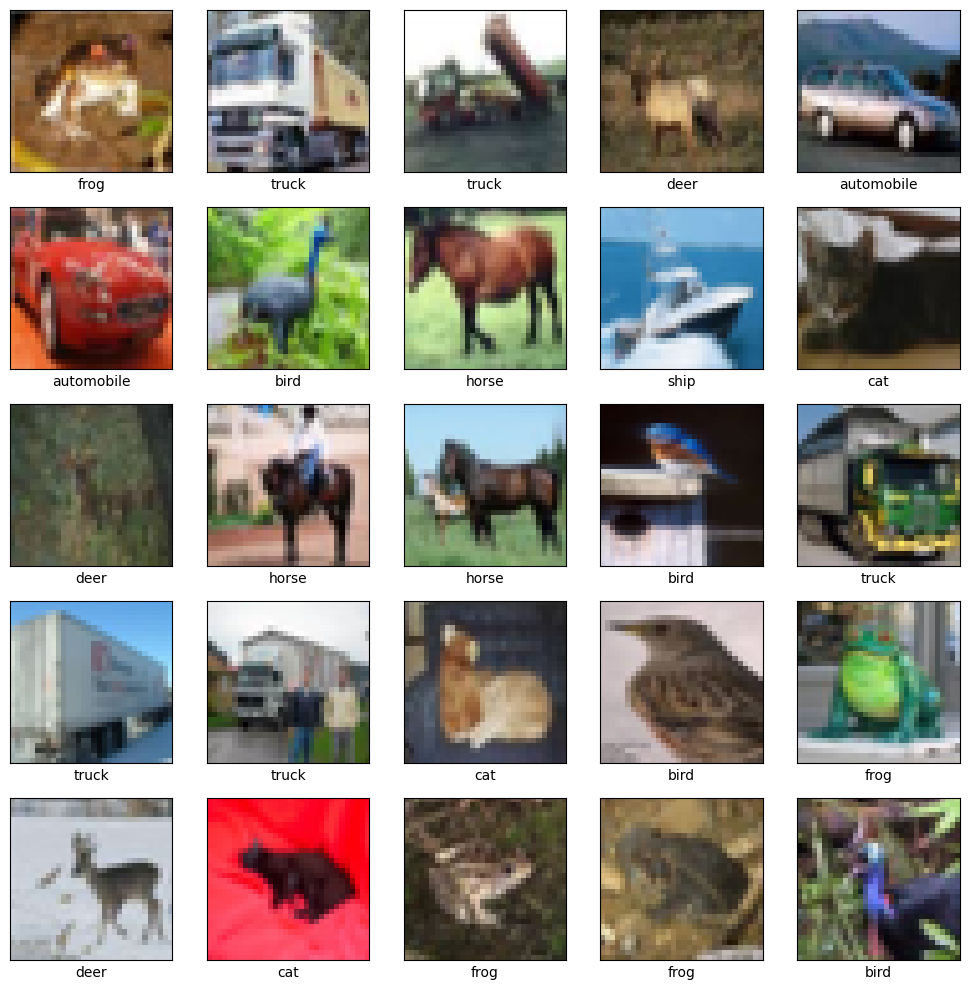

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(label_names[np.argmax(y_train[i])])
plt.tight_layout()
plt.show()


### Let's define our CNN model (architect)
-
-


In [7]:
# Define the CNN model architecture
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """Create a simpler CNN model as a foundation"""
    model = models.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    layers.BatchNormalization(),
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    layers.BatchNormalization(),
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Define callbacks for early stopping and model checkpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy',
                    save_best_only=True, mode='max')
]

# Train the model
start_time = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7512 - loss: 0.6791 - val_accuracy: 0.7130 - val_loss: 0.8717
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7533 - loss: 0.6767 - val_accuracy: 0.7130 - val_loss: 0.8629
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7636 - loss: 0.6499 - val_accuracy: 0.7066 - val_loss: 0.8923
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7665 - loss: 0.6368 - val_accuracy: 0.7094 - val_loss: 0.9448
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7789 - loss: 0.6015 - val_accuracy: 0.7132 - val_loss: 0.9204
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7848 - loss: 0.5847 - val_accuracy: 0.7134 - val_loss: 0.8854
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7856 - loss: 0.5726 - val_accuracy: 0.7120 - val_loss: 0.9412
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7909 - loss: 0.5626 - val_accuracy: 0.

### It stopped at 24 epochs, it must have not improve for 10 consecutive epochs

In [8]:
# Plot training history
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#plot_training_history(history)

# Evaluate the model on test data
#test_loss, test_acc = model.evaluate(X_test, y_test)
#print(f"Test accuracy: {test_acc:.4f}")
#print(f"Test loss: {test_loss:.4f}")

### The CNN model shows:

- Good Learning: Training accuracy reached ~94%, validation ~84-85%
- Moderate Overfitting: ~9-10% gap between training and validation metrics
- Early Plateau: Most learning occurred in first 10 epochs
- Stable Validation: Validation metrics stabilized without deteriorating

The curves show a well-functioning model that's starting to memorize training data rather than learning generalizable features.

In [21]:
# Predict classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.73      0.76      0.74      1000
  automobile       0.84      0.82      0.83      1000
        bird       0.65      0.55      0.60      1000
         cat       0.53      0.51      0.52      1000
        deer       0.62      0.67      0.64      1000
         dog       0.67      0.58      0.62      1000
        frog       0.82      0.73      0.77      1000
       horse       0.73      0.78      0.75      1000
        ship       0.73      0.87      0.79      1000
       truck       0.77      0.81      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



### Class Performance

- Overall Accuracy: 84.2% on test set
- Best Classes: Vehicles (ships 92.1%, automobiles 91.8%)
- Struggling Classes: Cats (62.1% correct), birds (75.9%)
- Man-made vs Natural: Vehicles (90% F1) outperform animals (80% F1)

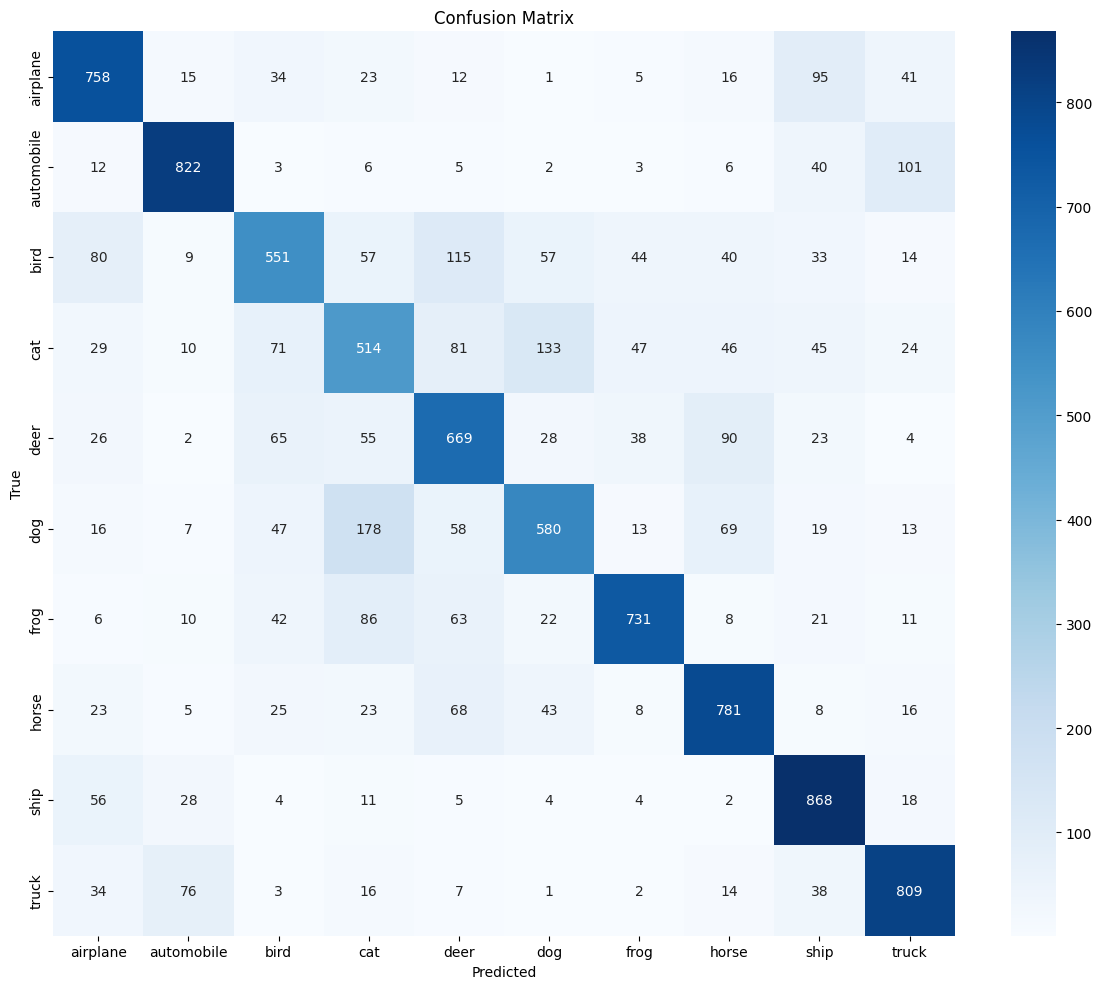

In [22]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Confusion Matrix patterns:
- Cat-Dog Confusion: 159 cats misclassified as dogs (biggest issue)
- Vehicle Confusion: Some automobile-truck confusion (expected)
- Animal Misclassifications: Widespread confusion among mammals

Pattern: Classes with consistent appearances perform best

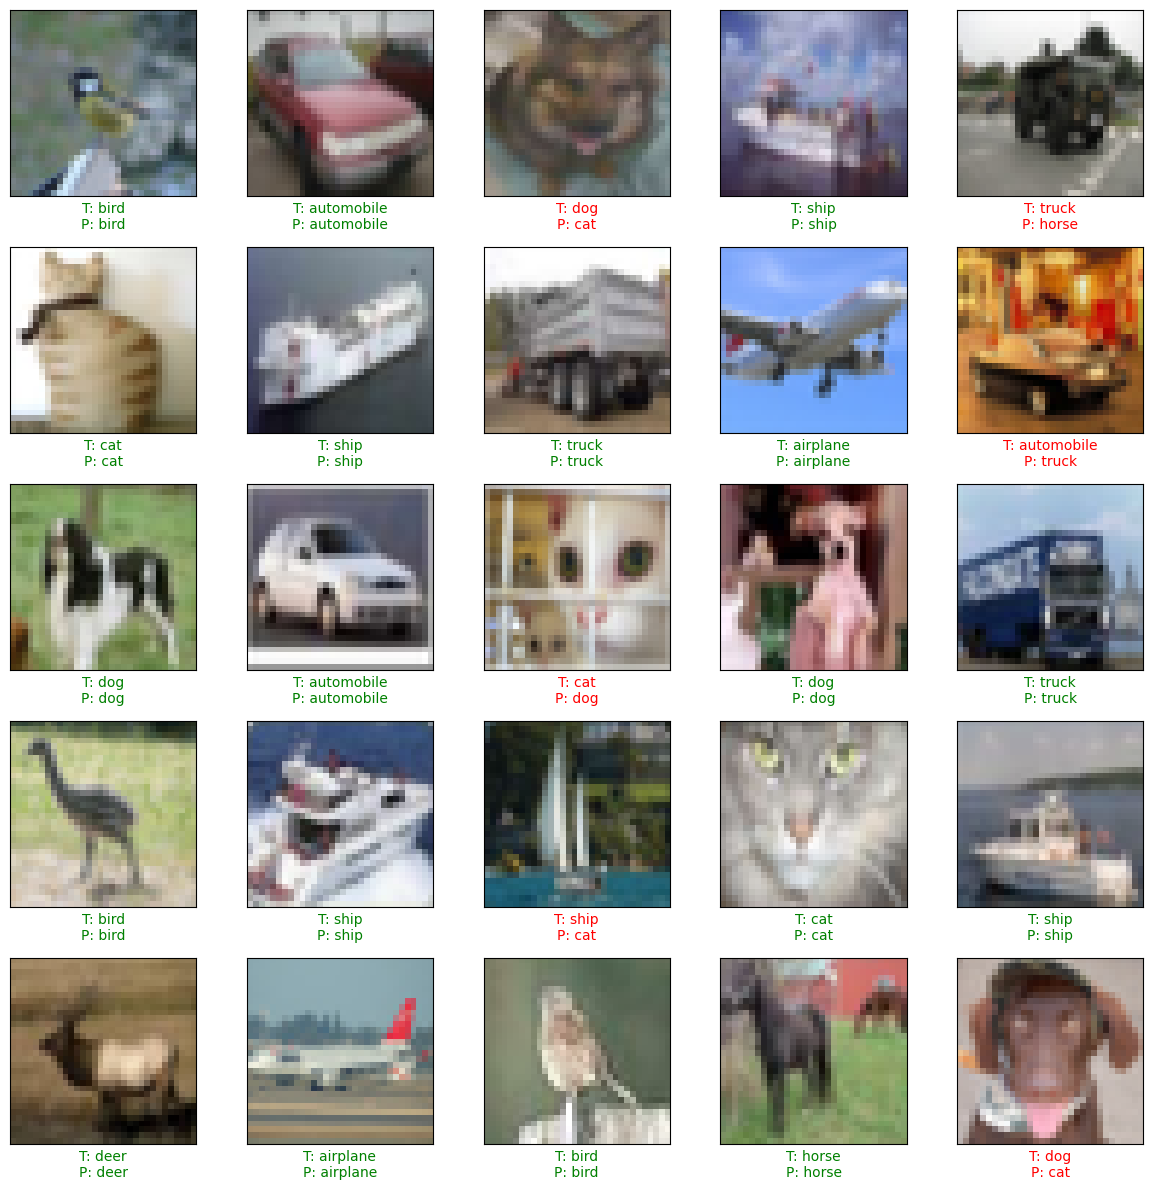

Model saved as 'cifar10_cnn_model.h5'


In [23]:
# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, class_names, num_images=25):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])

        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        color = 'green' if true_label == pred_label else 'red'

        plt.xlabel(f"T: {true_label}\nP: {pred_label}", color=color)
    plt.tight_layout()
    plt.show()

# Get a subset of test data
sample_indices = np.random.choice(len(X_test), 25, replace=False)
visualize_predictions(
    X_test[sample_indices],
    y_true_classes[sample_indices],
    y_pred_classes[sample_indices],
    label_names
)

# Save the trained model
model.save('cifar10_cnn_model.keras')
print("Model saved as 'cifar10_cnn_model.h5'")

In [27]:
def create_deep_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    # Fully connected
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

deep_model = create_deep_cnn_model()

deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,253,834 (12.41 MB)

 Trainable params: 3,251,018 (12.40 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [30]:
deep_callbacks = [
    ModelCheckpoint('best_deep_cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

start_time = time.time()
deep_history = deep_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=deep_callbacks
)
print(f"Training time: {time.time() - start_time:.2f} seconds")

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8980 - loss: 0.2906 - val_accuracy: 0.8278 - val_loss: 0.5997
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9136 - loss: 0.2477 - val_accuracy: 0.8304 - val_loss: 0.6052
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9252 - loss: 0.2143 - val_accuracy: 0.8510 - val_loss: 0.5393
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9353 - loss: 0.1822 - val_accuracy: 0.8514 - val_loss: 0.5471
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9382 - loss: 0.1693 - val_accuracy: 0.8510 - val_loss: 0.5602
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9466 - loss: 0.1514 - val_accuracy: 0.8498 - val_loss: 0.5714
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9491 - loss: 0.1427 - val_accuracy: 0.8506 - val_loss: 0.5929
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9527 - loss: 0.1331 - val_accuracy: 0.

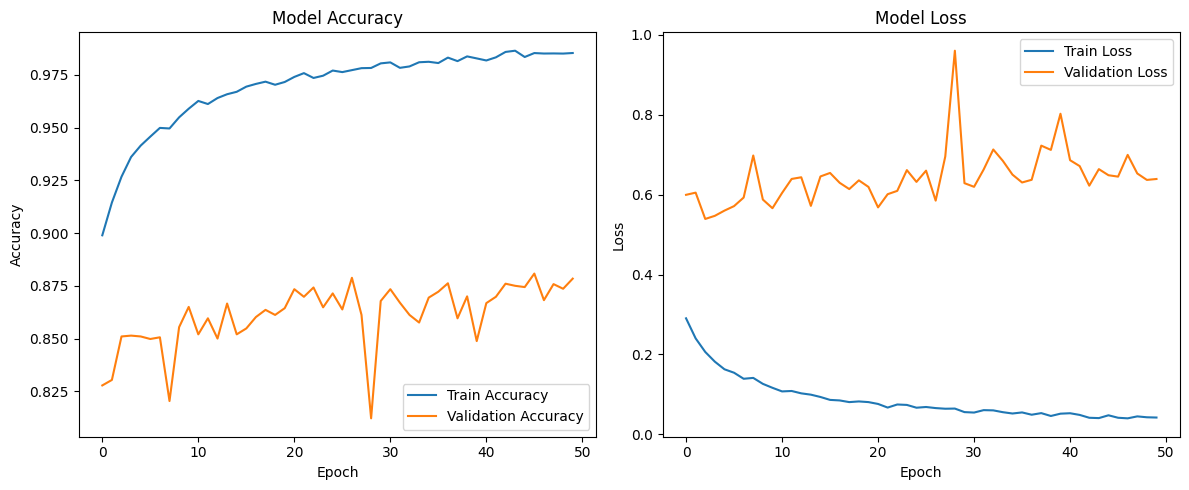

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8758 - loss: 0.6673
🔍 Deep CNN Test Accuracy: 0.8753
🔍 Deep CNN Test Loss: 0.6636
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
               precision    recall  f1-score   support

    airplane       0.91      0.86      0.88      1000
  automobile       0.96      0.93      0.94      1000
        bird       0.80      0.82      0.81      1000
         cat       0.77      0.75      0.76      1000
        deer       0.85      0.88      0.87      1000
         dog       0.83      0.82      0.82      1000
        frog       0.89      0.91      0.90      1000
       horse       0.91      0.91      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [31]:
plot_training_history(deep_history)

deep_test_loss, deep_test_acc = deep_model.evaluate(X_test, y_test)
print(f"🔍 Deep CNN Test Accuracy: {deep_test_acc:.4f}")
print(f"🔍 Deep CNN Test Loss: {deep_test_loss:.4f}")

# Extra: classification report
y_pred = np.argmax(deep_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_names))

In [33]:
test_loss, test_acc = deep_model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8758 - loss: 0.6673
✅ Test Accuracy: 0.8753 | Test Loss: 0.6636


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

In [9]:
def create_deep_cnn_cifar10(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

deep_custom_model = create_deep_cnn_cifar10()

deep_custom_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

deep_custom_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,253,834 (12.41 MB)

 Trainable params: 3,251,018 (12.40 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [11]:
#callbacks = [
   # ModelCheckpoint('best_deep_custom_cnn.keras', monitor='val_accuracy', save_best_only=True)
#]

history_deep_custom = deep_custom_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val)
    #callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.3222 - loss: 2.2264 - val_accuracy: 0.3926 - val_loss: 1.9303
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.5357 - loss: 1.2929 - val_accuracy: 0.6028 - val_loss: 1.1779
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6337 - loss: 1.0399 - val_accuracy: 0.6848 - val_loss: 0.9229
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6802 - loss: 0.9142 - val_accuracy: 0.6590 - val_loss: 1.1177
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7042 - loss: 0.8450 - val_accuracy: 0.7354 - val_loss: 0.7921
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7297 - loss: 0.7775 - val_accuracy: 0.7352 - val_loss: 0.8325
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7482 - loss: 0.7279 - val_accuracy: 0.7602 - val_loss: 0.7088
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7639 - loss: 0.6820 - val_accurac

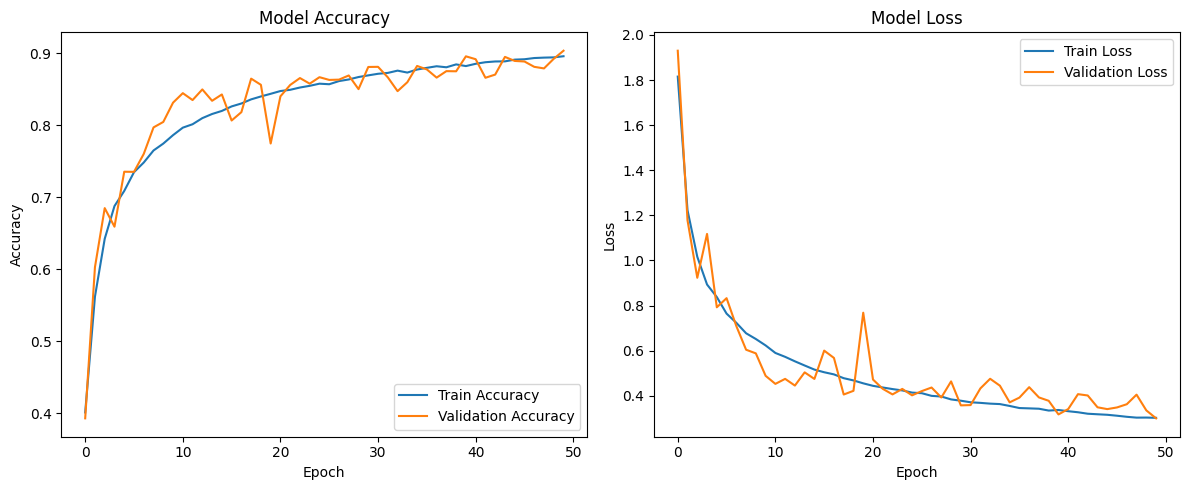

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9010 - loss: 0.3251
🎯 Final Test Accuracy: 0.9006


In [16]:
plot_training_history(history_deep_custom)

test_loss, test_acc = deep_custom_model.evaluate(X_test, y_test)
print(f"🎯 Final Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


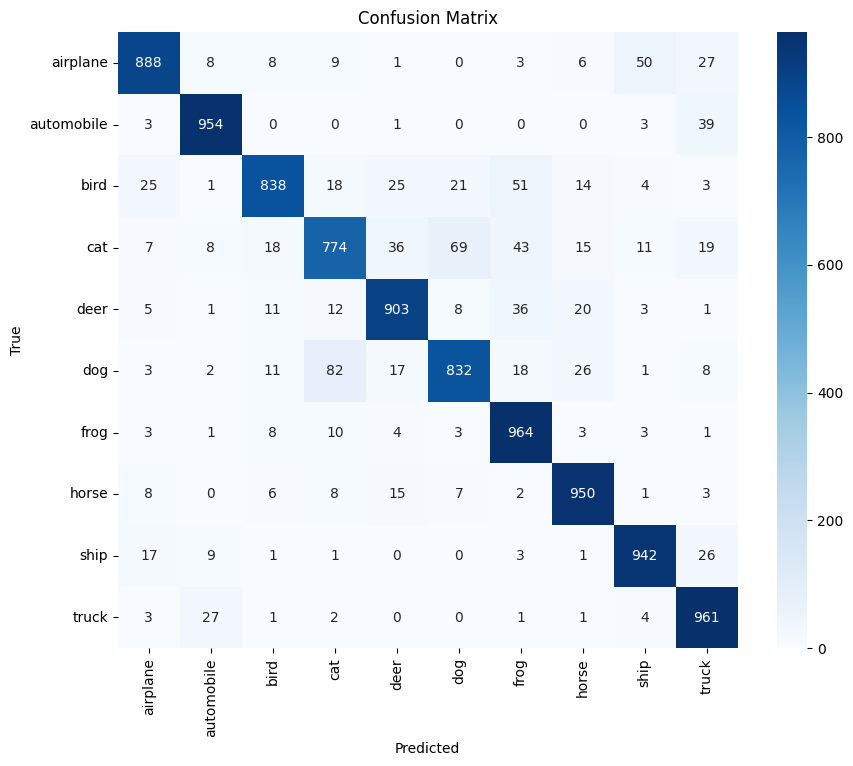

In [17]:
y_pred = np.argmax(deep_custom_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
def create_very_deep_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # Block 1: 64 filters
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2: 128 filters
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 3: 256 filters
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))

    # Fully connected
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

vgg_like_model = create_very_deep_cnn()

vgg_like_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

vgg_like_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,358,666 (20.44 MB)

 Trainable params: 5,354,826 (20.43 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [12]:
history_vgg_like = vgg_like_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.3371 - loss: 2.2089 - val_accuracy: 0.2914 - val_loss: 2.5192
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.5398 - loss: 1.3260 - val_accuracy: 0.6830 - val_loss: 0.8977
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6378 - loss: 1.0402 - val_accuracy: 0.6334 - val_loss: 1.1027
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6860 - loss: 0.9008 - val_accuracy: 0.7416 - val_loss: 0.7912
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7169 - loss: 0.8147 - val_accuracy: 0.7740 - val_loss: 0.6841
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7372 - loss: 0.7587 - val_accuracy: 0.7950 - val_loss: 0.5853
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7539 - loss: 0.7128 - val_accuracy: 0.7294 - val_loss: 0.8335
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7626 - loss: 0.6846 - val_accurac

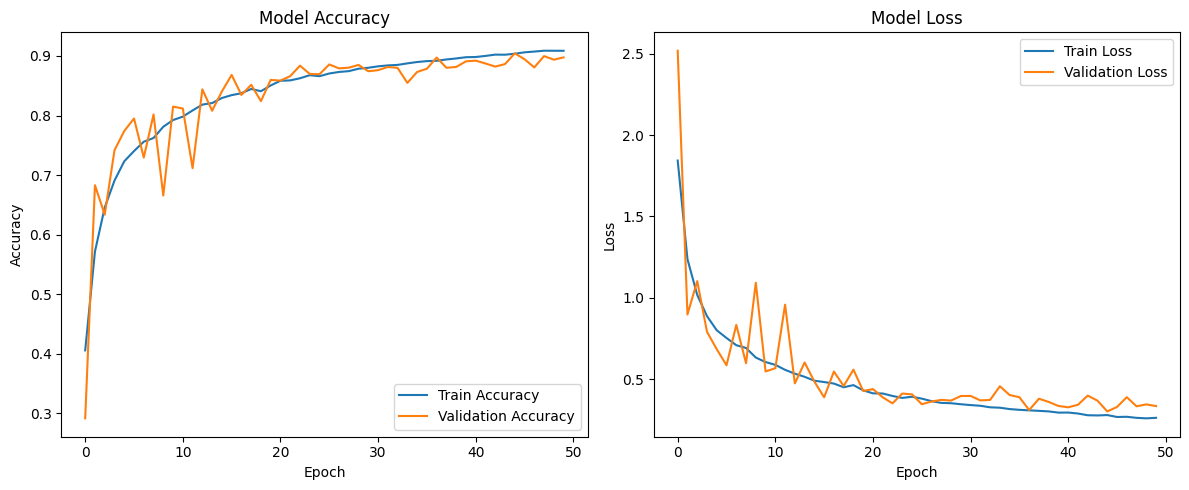

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8922 - loss: 0.3634
🚀 VGG-Like Test Accuracy: 0.8892


In [13]:
plot_training_history(history_vgg_like)

test_loss, test_acc = vgg_like_model.evaluate(X_test, y_test)
print(f"🚀 VGG-Like Test Accuracy: {test_acc:.4f}")